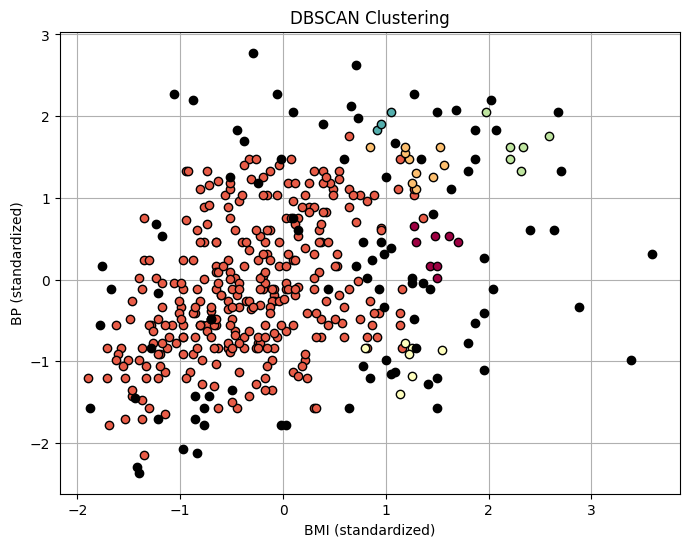

Deduplicated Records (One representative per cluster):
        age       sex       bmi        bp        s1        s2        s3  \
0  0.041708  0.050680  0.071397  0.008101  0.038334  0.015909 -0.017629   
1 -0.005515  0.050680 -0.008362 -0.002228 -0.033216 -0.063630 -0.036038   
2  0.023546  0.050680  0.061696  0.062050  0.024574 -0.036073 -0.091262   
3  0.005383 -0.044642  0.058463 -0.043542 -0.073119 -0.072399  0.019187   
4  0.030811 -0.044642  0.104809  0.076958 -0.011201 -0.011335 -0.058127   
5 -0.005515 -0.044642  0.043373  0.087287  0.013567  0.007141 -0.013948   

         s4        s5        s6  target  
0  0.034309  0.073407  0.085907   295.0  
1 -0.002592  0.080590  0.007207   161.0  
2  0.155345  0.133397  0.081764   242.0  
3 -0.076395 -0.051404 -0.025930   136.0  
4  0.034309  0.057108  0.036201   270.0  
5 -0.002592  0.042341 -0.017646   195.0  


In [5]:
# DBSCAN for Data Deduplication

# Step 1: Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances_argmin_min

# Step 2: Load the Diabetes Dataset
diabetes = load_diabetes()
data = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)
data['target'] = diabetes.target

# Step 3: Select Features for Analysis
selected_features = ['age', 'bmi', 'bp']
df = data[selected_features].copy()

# Step 4: Standardize the Features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Step 5: Apply DBSCAN Clustering
# Parameters: eps (maximum distance between two samples for them to be considered as in the same neighborhood)
#             min_samples (number of samples in a neighborhood for a point to be considered as a core point)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(df_scaled)
df['Cluster'] = dbscan.labels_

# Step 6: Identify Representative Records (Deduplication)
# Exclude noise points labeled as -1
unique_clusters = set(dbscan.labels_)
unique_clusters.discard(-1)  # Remove noise label

representative_indices = []
for cluster in unique_clusters:
    cluster_indices = df[df['Cluster'] == cluster].index
    cluster_points = df_scaled[cluster_indices]
    centroid = cluster_points.mean(axis=0).reshape(1, -1)
    closest, _ = pairwise_distances_argmin_min(centroid, cluster_points)
    representative_index = cluster_indices[closest[0]]
    representative_indices.append(representative_index)

deduplicated_data = data.loc[representative_indices].reset_index(drop=True)

# Step 7: Visualize Clusters
plt.figure(figsize=(8, 6))
unique_labels = set(dbscan.labels_)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (dbscan.labels_ == k)

    xy = df_scaled[class_member_mask]
    plt.plot(xy[:, 1], xy[:, 2], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('DBSCAN Clustering')
plt.xlabel('BMI (standardized)')
plt.ylabel('BP (standardized)')
plt.grid(True)
plt.show()

# Step 8: Output Deduplicated Records
print("Deduplicated Records (One representative per cluster):")
print(deduplicated_data)